In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functions import build_model, WindowGenerator, fit_and_plot
import tensorflow as tf
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data cleaning

In [5]:
df = pd.read_csv("data/no1_train.csv")
df_validation = pd.read_csv("data/no1_validation.csv")

percent = 0.005
upper_bound = df.y.quantile(1-percent/2)
lower_bound = df.y.quantile(percent/2)

print("Upper bound:", upper_bound)
print("Lower bound:", lower_bound)
clamped_points = (df.y < lower_bound).sum() + (df.y > upper_bound).sum()

print("Points clamped: %d. In percent %.4f%%" % (clamped_points, (clamped_points / len(df.y)) * 100))
df.y.where(df.y > lower_bound, lower_bound, inplace=True)
df.y.where(df.y < upper_bound, upper_bound, inplace=True)

df_validation.y.where(df_validation.y > lower_bound, lower_bound, inplace=True)
df_validation.y.where(df_validation.y < upper_bound, upper_bound, inplace=True)

Upper bound: 1965.4099018235388
Lower bound: -876.8264394156931
Points clamped: 1126. In percent 0.5002%


0.010875746374751208


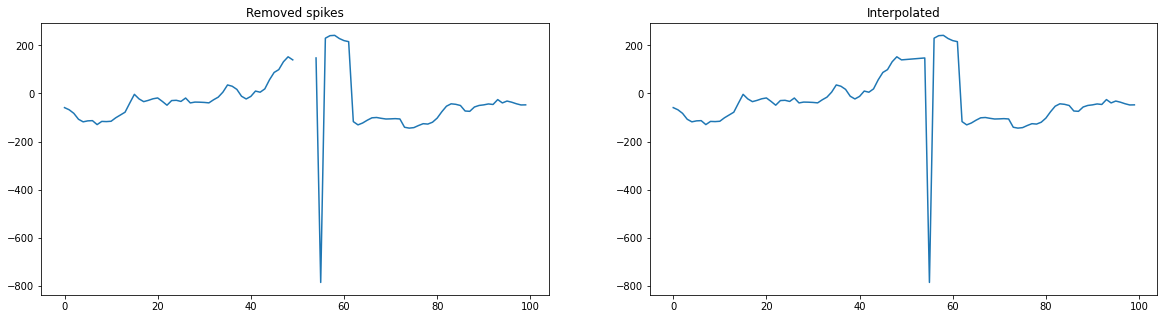

In [4]:
def interpolate_target_data(df_train, df_test, visualise=True):
	min_value = df_train.y.min()
	max_value = df_train.y.max()
	df_copy = df_test.copy()
	print( (len(df_copy) - df_copy.y.between(min_value, max_value).sum()) / len(df_copy))
	df_copy.y.where(df_copy.y.between(min_value, max_value), np.nan, inplace=True)

	if visualise:
		fig, ax = plt.subplots(1,2, figsize=(20,5))
		critical_point = df_test.y.argmin()  # a critical point of y data
		ax[0].plot(df_copy["y"][critical_point-50:critical_point+50].values) # The critical part of y data
		ax[0].set_title("Removed spikes")

		inter_df = df_copy["y"].interpolate(method='linear', inplace=False)
		ax[1].plot(inter_df[critical_point-50:critical_point+50].values)
		ax[1].set_title("Interpolated")
		plt.show()

	df_copy["y"].interpolate(method='linear', inplace=True)
	return df_copy
df_cleaned = interpolate_target_data(df, df_validation, visualise=True)

In [ ]:
df_cleaned.y.min(), df_cleaned.y.max(), df_cleaned.y.mean(), df_cleaned.y.std()

## Add features

In [8]:
from functions import add_time_features, add_lag_features

column_indcies = ['hydro', 'micro', 'thermal', 'wind', 'total',
        'sys_reg', 'flow', 'Minute sine', 'Minute cosine', 'Hour sine',
       'Hour cosine', 'Day sine', 'Day cosine', 'Month sine', 'Month cosine',
       'Week sine', 'Week cosine', 'prev_y_1', 'y']

train_df = add_time_features(df)
train_df = add_lag_features(df, 1)[column_indcies]

test_df = add_time_features(df_validation)
test_df = add_lag_features(df_validation, 1)[column_indcies]

In [19]:
test_df.head()

,hydro,micro,thermal,wind,total,sys_reg,flow,Minute sine,Minute cosine,Hour sine,Hour cosine,Day sine,Day cosine,Month sine,Month cosine,Week sine,Week cosine,prev_y_1,y
2,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,-0.866025,-5.000000e-01,0.707107,0.707107,0.017201,0.999852,1.0,6.123234e-17,0.885456,0.464723,90.374541,88.435063
3,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,-1.000000,-1.836970e-16,0.707107,0.707107,0.017201,0.999852,1.0,6.123234e-17,0.885456,0.464723,88.435063,53.375518
4,1942.490,191.881,20.1,106.431,2266.102,0.0,-2252.90,-0.866025,5.000000e-01,0.707107,0.707107,0.017201,0.999852,1.0,6.123234e-17,0.885456,0.464723,53.375518,65.496683
5,1942.490,191.881,20.1,106.431,2266.102,0.0,-2275.84,-0.500000,8.660254e-01,0.707107,0.707107,0.017201,0.999852,1.0,6.123234e-17,0.885456,0.464723,65.496683,96.450851
6,1977.158,187.109,20.1,116.534,2306.101,0.0,-2333.19,0.000000,1.000000e+00,0.866025,0.500000,0.017201,0.999852,1.0,6.123234e-17,0.885456,0.464723,96.450851,8.254687


## Ready for training

In [20]:
%autoreload
generator = WindowGenerator(train_data=train_df[-12*24*60:], test_data=test_df, validation_data=None, target="y",
							n_input=12*12, n_output=1, shift=1, num_predictions=12*2)
generator.getTrainData()

<MapDataset element_spec=(TensorSpec(shape=(None, 144, 18), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [21]:
model = build_model(generator.getInputShape(), load_prev_model=False)
#model = build_model(load_prev_model="model_weights/lstm_512_epochs20_alldata.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                21248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [22]:

model = fit_and_plot(model, generator.getTrainData(), generator.getTestData(), epochs=10)

Epoch 1/10
536/536 [==============================] - 51s 91ms/step - loss: 0.2932 - mean_absolute_error: 0.3875 - val_loss: 1.0205 - val_mean_absolute_error: 0.8677
Epoch 2/10
536/536 [==============================] - 70s 131ms/step - loss: 0.1327 - mean_absolute_error: 0.2662 - val_loss: 0.2921 - val_mean_absolute_error: 0.4052
Epoch 3/10
536/536 [==============================] - 113s 211ms/step - loss: 0.0798 - mean_absolute_error: 0.2048 - val_loss: 0.2496 - val_mean_absolute_error: 0.3709
Epoch 4/10
381/536 [====================>.........] - ETA: 17s - loss: 0.0640 - mean_absolute_error: 0.1854

KeyboardInterrupt: 

In [ ]:
generator.predict_and_plot(model, data_raw=test_df, start_positions=[0,100, 200, 300, 400, 500, 600, 700], save_plot=False)